# __Credit Card Fraud Detection Using Machine Learning__

## Introduction 
In this kernel we will use various predictive models to see how accurate they are in detecting whether a transaction is a normal payment or a fraud. As described in the dataset, the features are scaled and the names of the features are not shown due to privacy reasons. Nevertheless, we can still analyze some important aspects of the dataset. Let's start!

### _About Dataset_
__Context__

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

__Content__


The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

__Update (03/05/2021)__


A simulator for transaction data has been released as part of the practical handbook on Machine Learning for Credit Card Fraud Detection - https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html. We invite all practitioners interested in fraud detection datasets to also check out this data simulator, and the methodologies for credit card fraud detection presented in the book.

Data Set URL:https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud 

In [1]:
######################## Credit Card Fraud Detection Using Machine Learning Project ###############

# Import necessary libraries 
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # For handling missing values
from sklearn.metrics import precision_recall_curve, auc, classification_report, average_precision_score, accuracy_score, precision_recall_fscore_support as prf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from keras import Input  # For handling the input layer correctly in the RNN model
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Load the dataset
df = pd.read_csv('creditcard.csv')
df.head() # View the first few rows of the dataset

In [3]:
# Data Exploration
print(df.info())  # Get a summary of the dataset, including data types and missing values
print(df.describe())  # Get summary statistics of the dataset


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [4]:

#  Identify Missing Values
print("Checking for missing values in the dataset:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Checking for missing values in the dataset:
Series([], dtype: int64)


In [5]:

#  Feature Engineering - Handling Missing Values
# Imputation Strategy: Replace missing values with the mean (or median, or most frequent)
imputer = SimpleImputer(strategy='mean')  # You can change strategy to 'median' or 'most_frequent'
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


In [6]:

# Check if missing values have been imputed
print("Checking for missing values after imputation:")
print(df_imputed.isnull().sum())


Checking for missing values after imputation:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


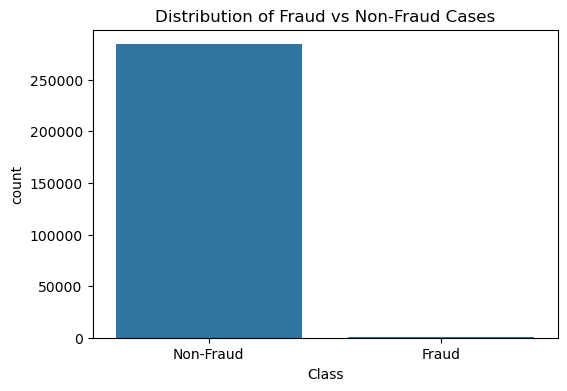

In [7]:
# Data Visualization
# Figure 1: Distribution of Fraud vs Non-Fraud Cases
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df_imputed)
plt.title('Distribution of Fraud vs Non-Fraud Cases')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

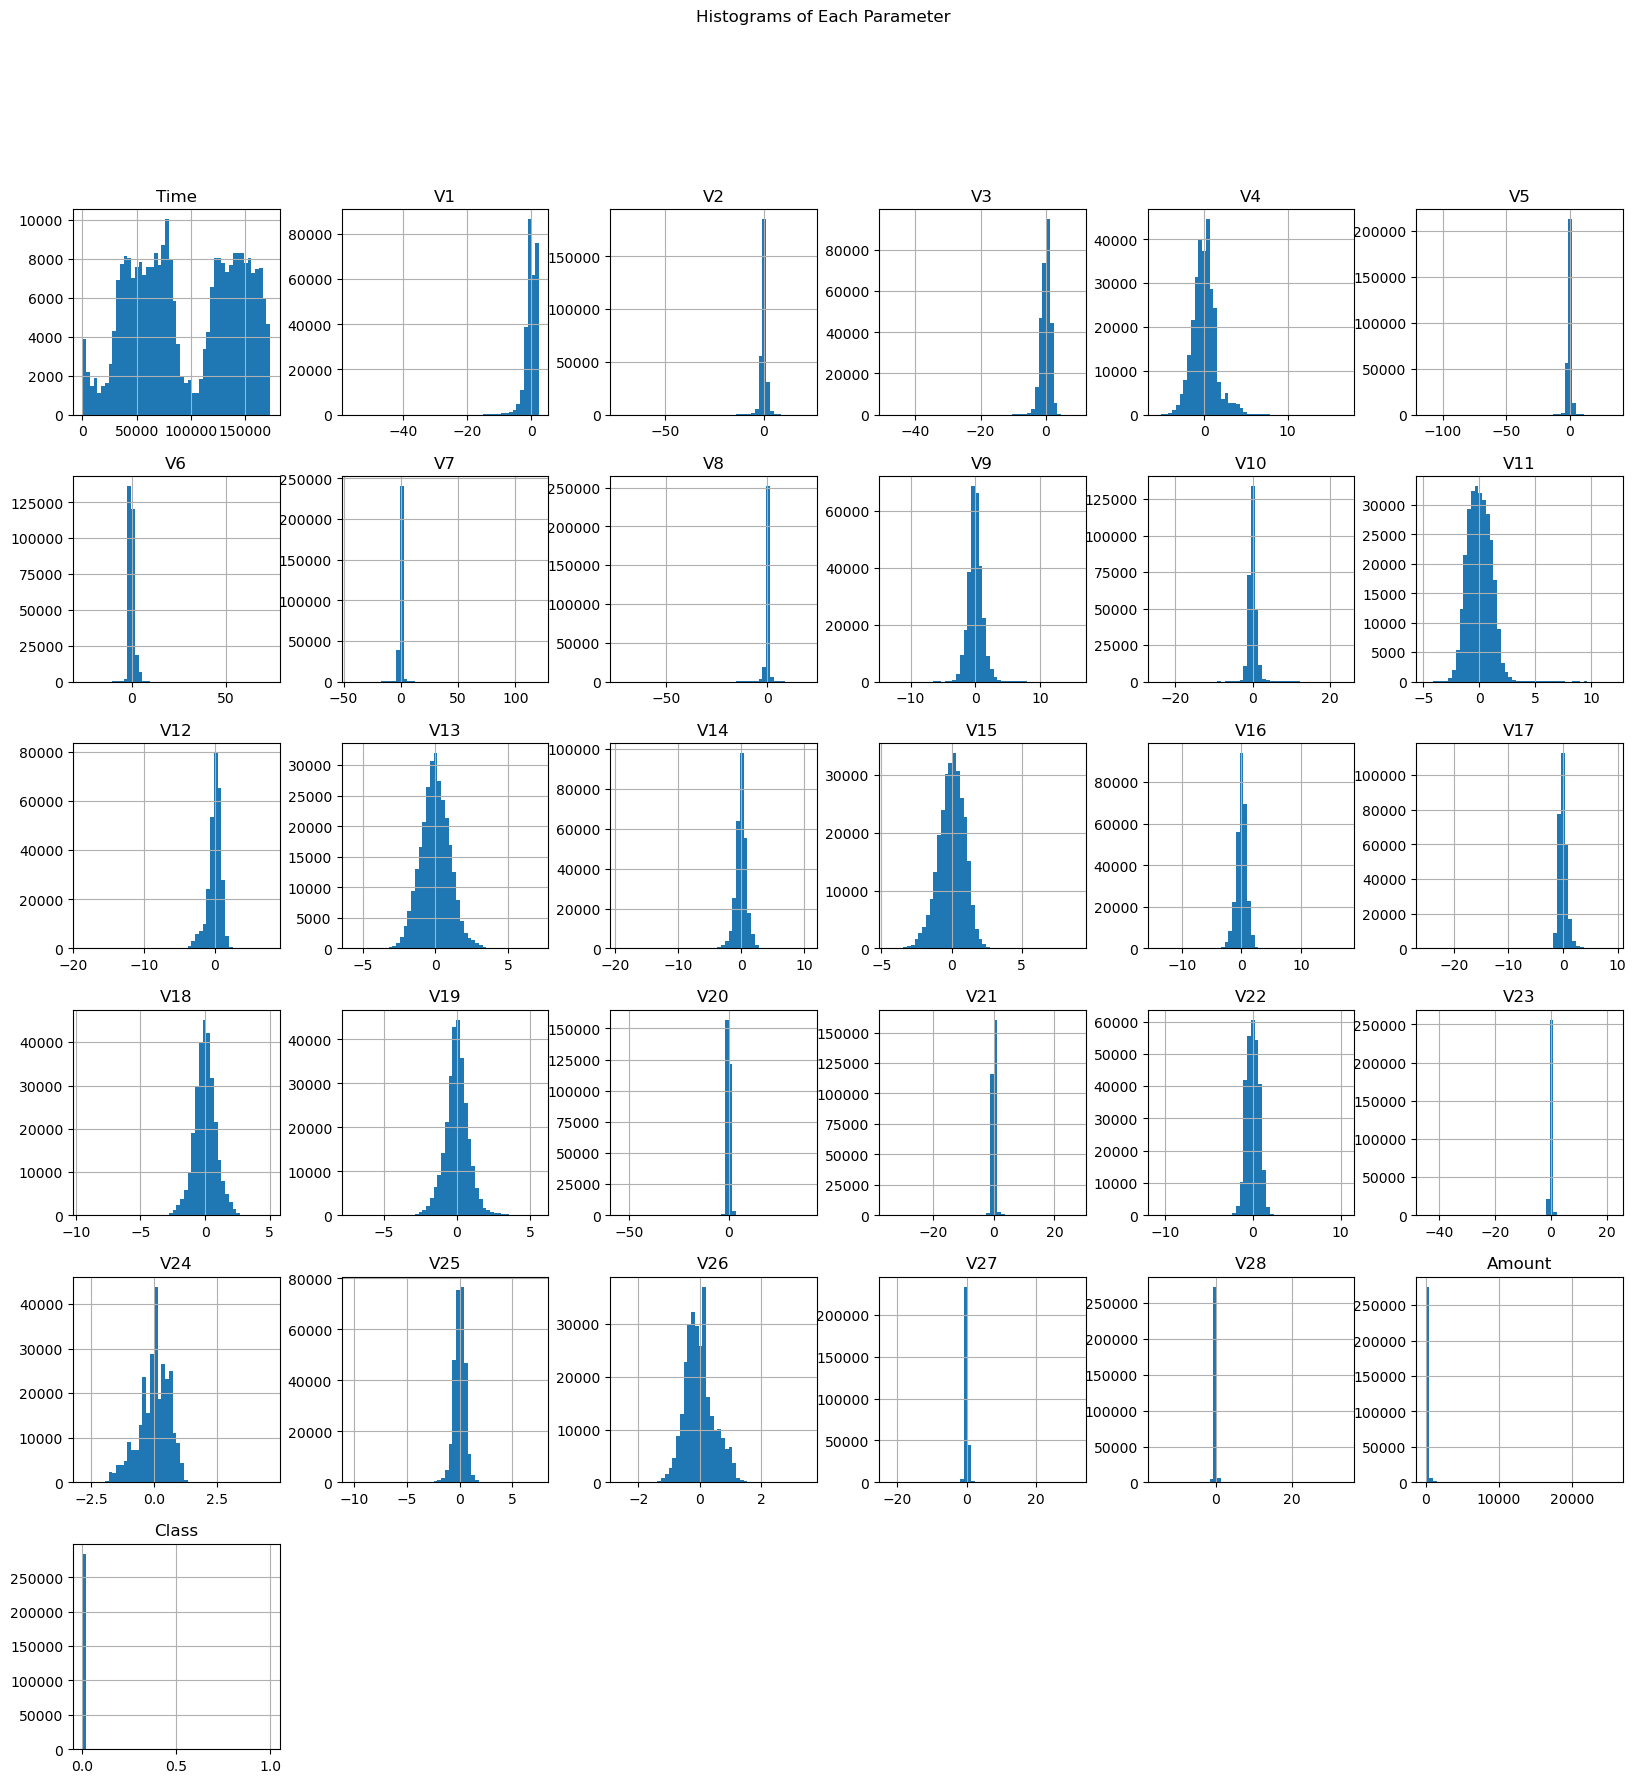

In [8]:

# Figure 2: Histograms of Each Parameter
df_imputed.hist(figsize=(20, 20), bins=50)
plt.suptitle('Histograms of Each Parameter')
plt.show()


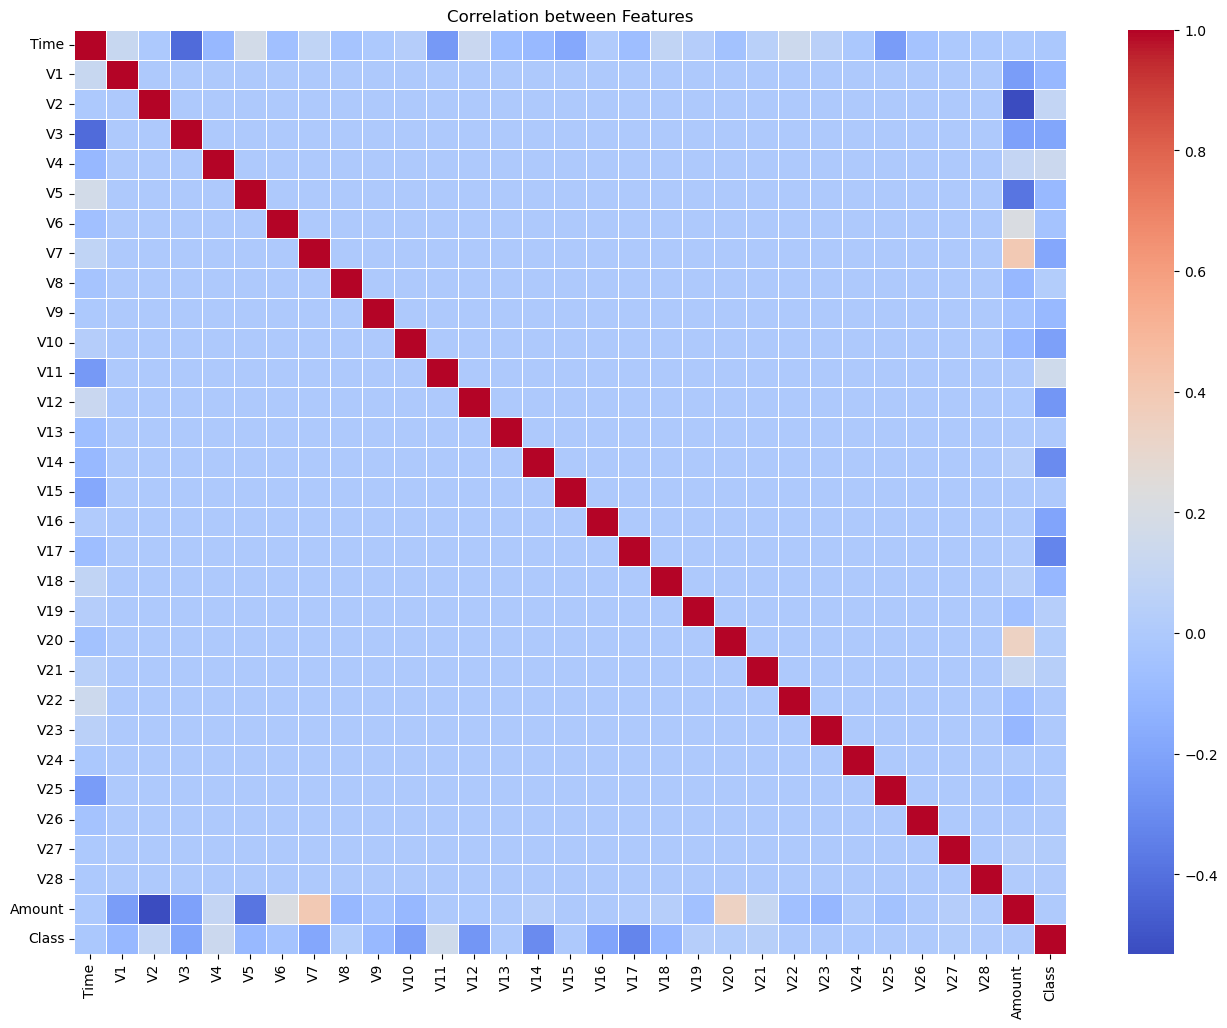

In [9]:

# Figure 3: Correlation between features using a heatmap
plt.figure(figsize=(16, 12))
corr_matrix = df_imputed.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between Features')
plt.show()


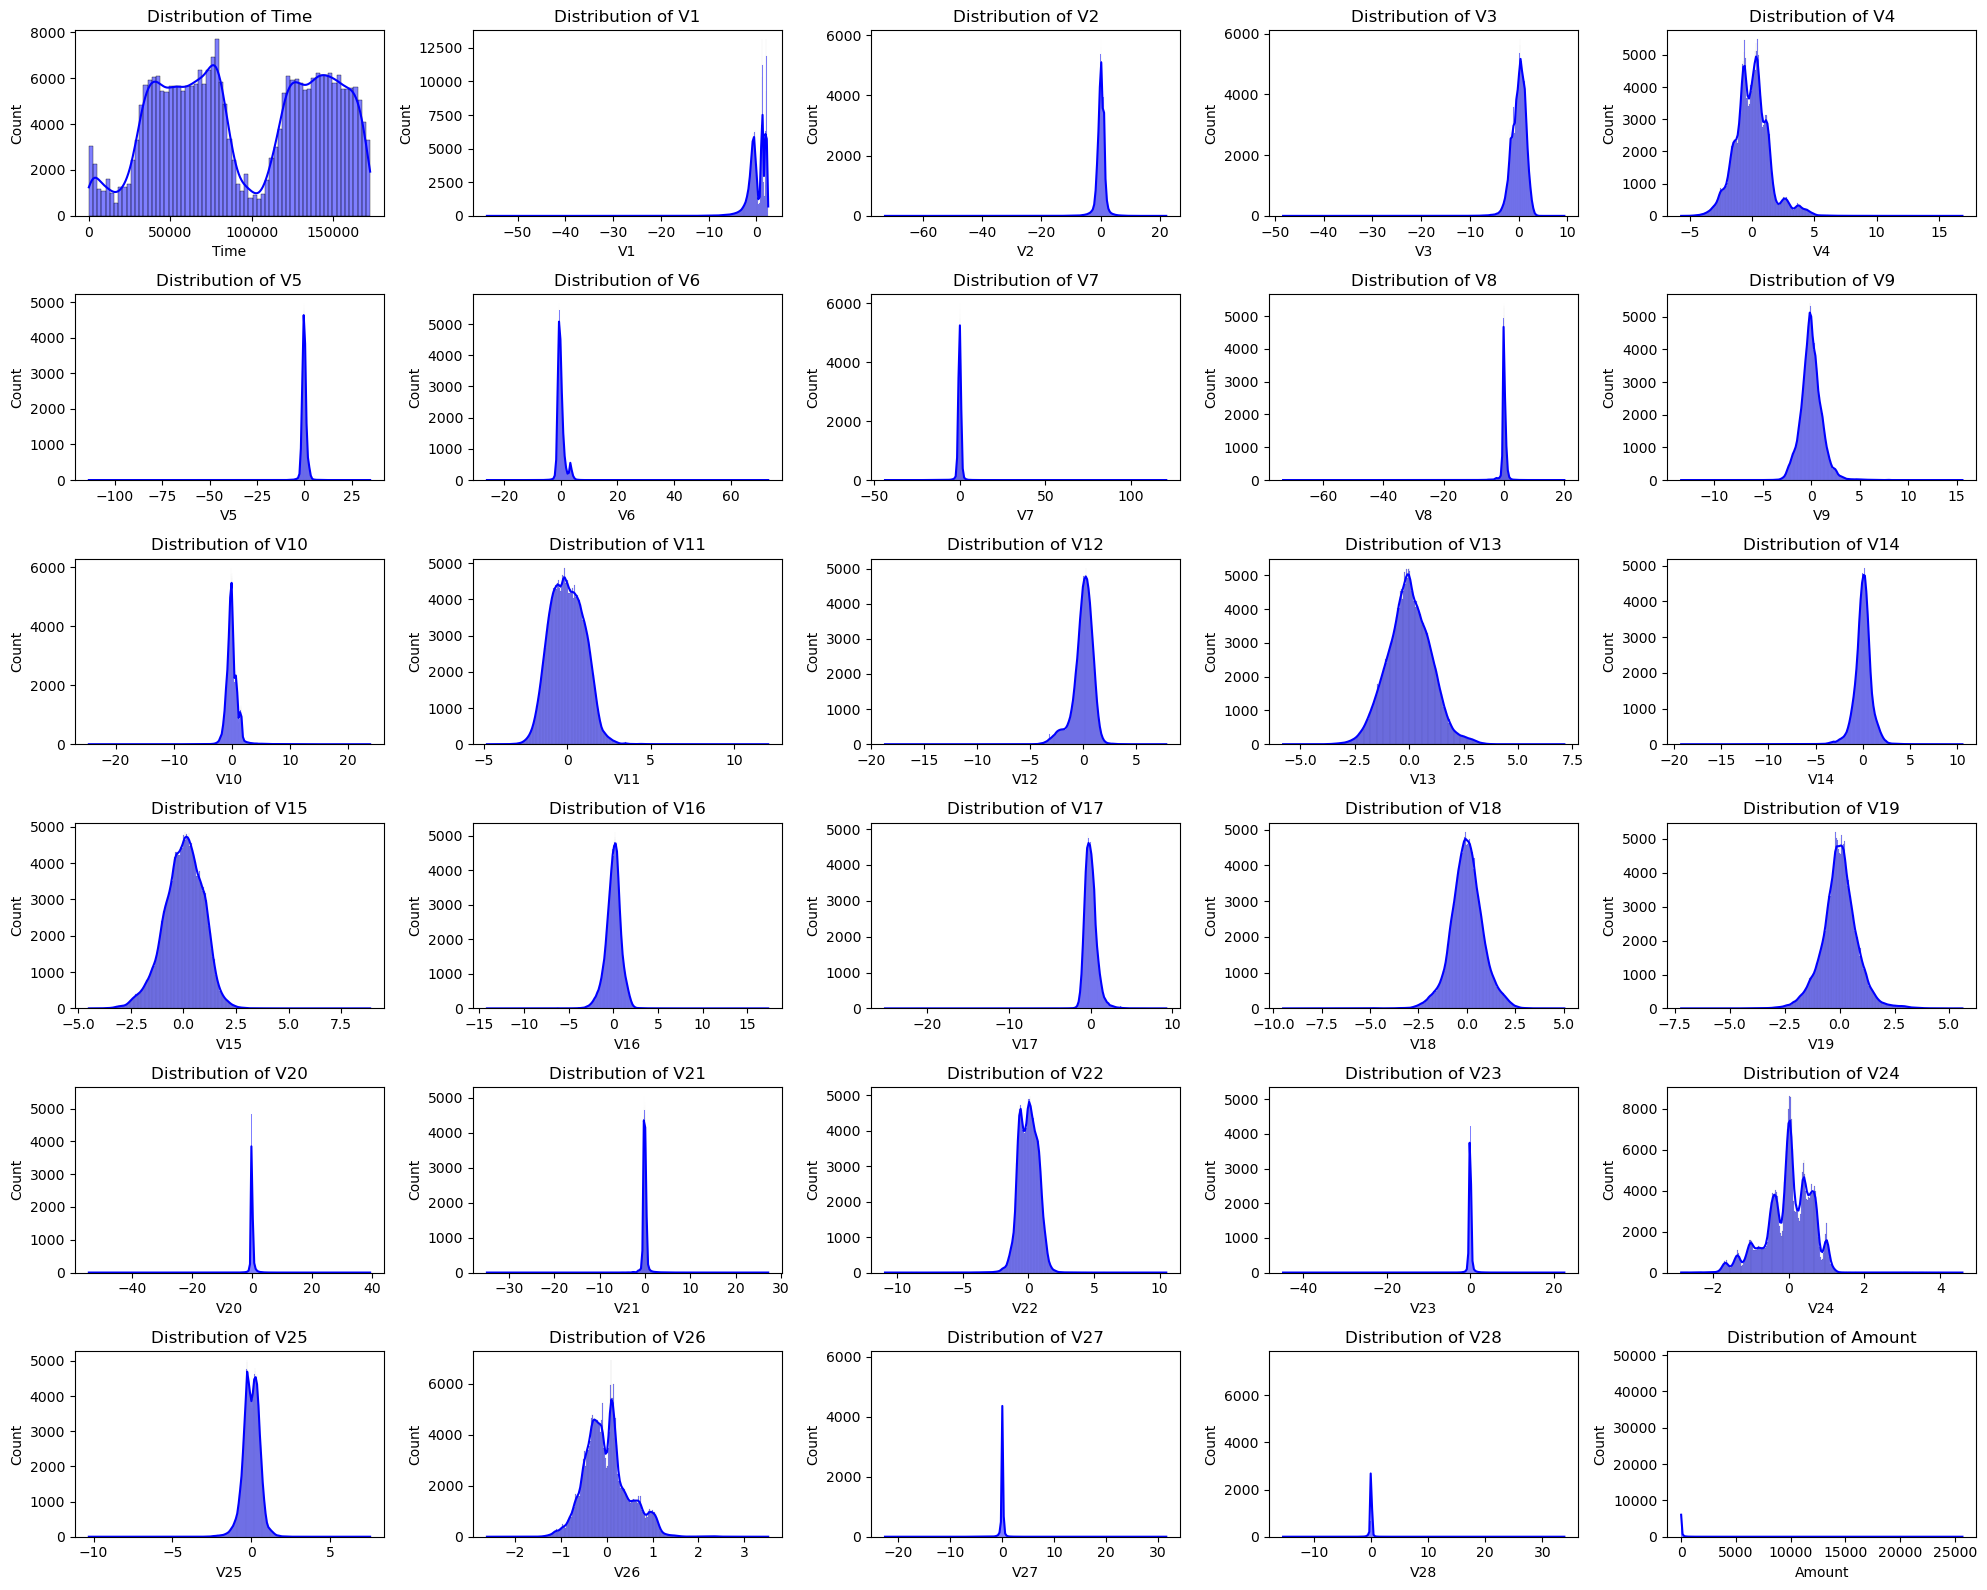

In [10]:
# Analyze Feature Distributions and Apply Transformation (If Needed)
plt.figure(figsize=(20, 16))
for i, col in enumerate(df_imputed.columns[:-1]):  # Exclude 'Class' column (target)
    plt.subplot(6, 5, i+1)  # 6 rows, 5 columns of subplots
    sns.histplot(df_imputed[col], kde=True, color='blue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [11]:

# Check for skewness in each feature
skewness = df_imputed.drop('Class', axis=1).skew()
print("Skewness of each feature:\n", skewness)


Skewness of each feature:
 Time      -0.035568
V1        -3.280667
V2        -4.624866
V3        -2.240155
V4         0.676292
V5        -2.425901
V6         1.826581
V7         2.553907
V8        -8.521944
V9         0.554680
V10        1.187141
V11        0.356506
V12       -2.278401
V13        0.065233
V14       -1.995176
V15       -0.308423
V16       -1.100966
V17       -3.844914
V18       -0.259880
V19        0.109192
V20       -2.037155
V21        3.592991
V22       -0.213258
V23       -5.875140
V24       -0.552499
V25       -0.415793
V26        0.576693
V27       -1.170209
V28       11.192091
Amount    16.977724
dtype: float64


In [12]:

# Apply log transformation to highly skewed features with safe handling for invalid values
for col in skewness[abs(skewness) > 1].index:
    df_imputed[col] = df_imputed[col].apply(lambda x: np.log1p(x) if x >= 0 else 0)

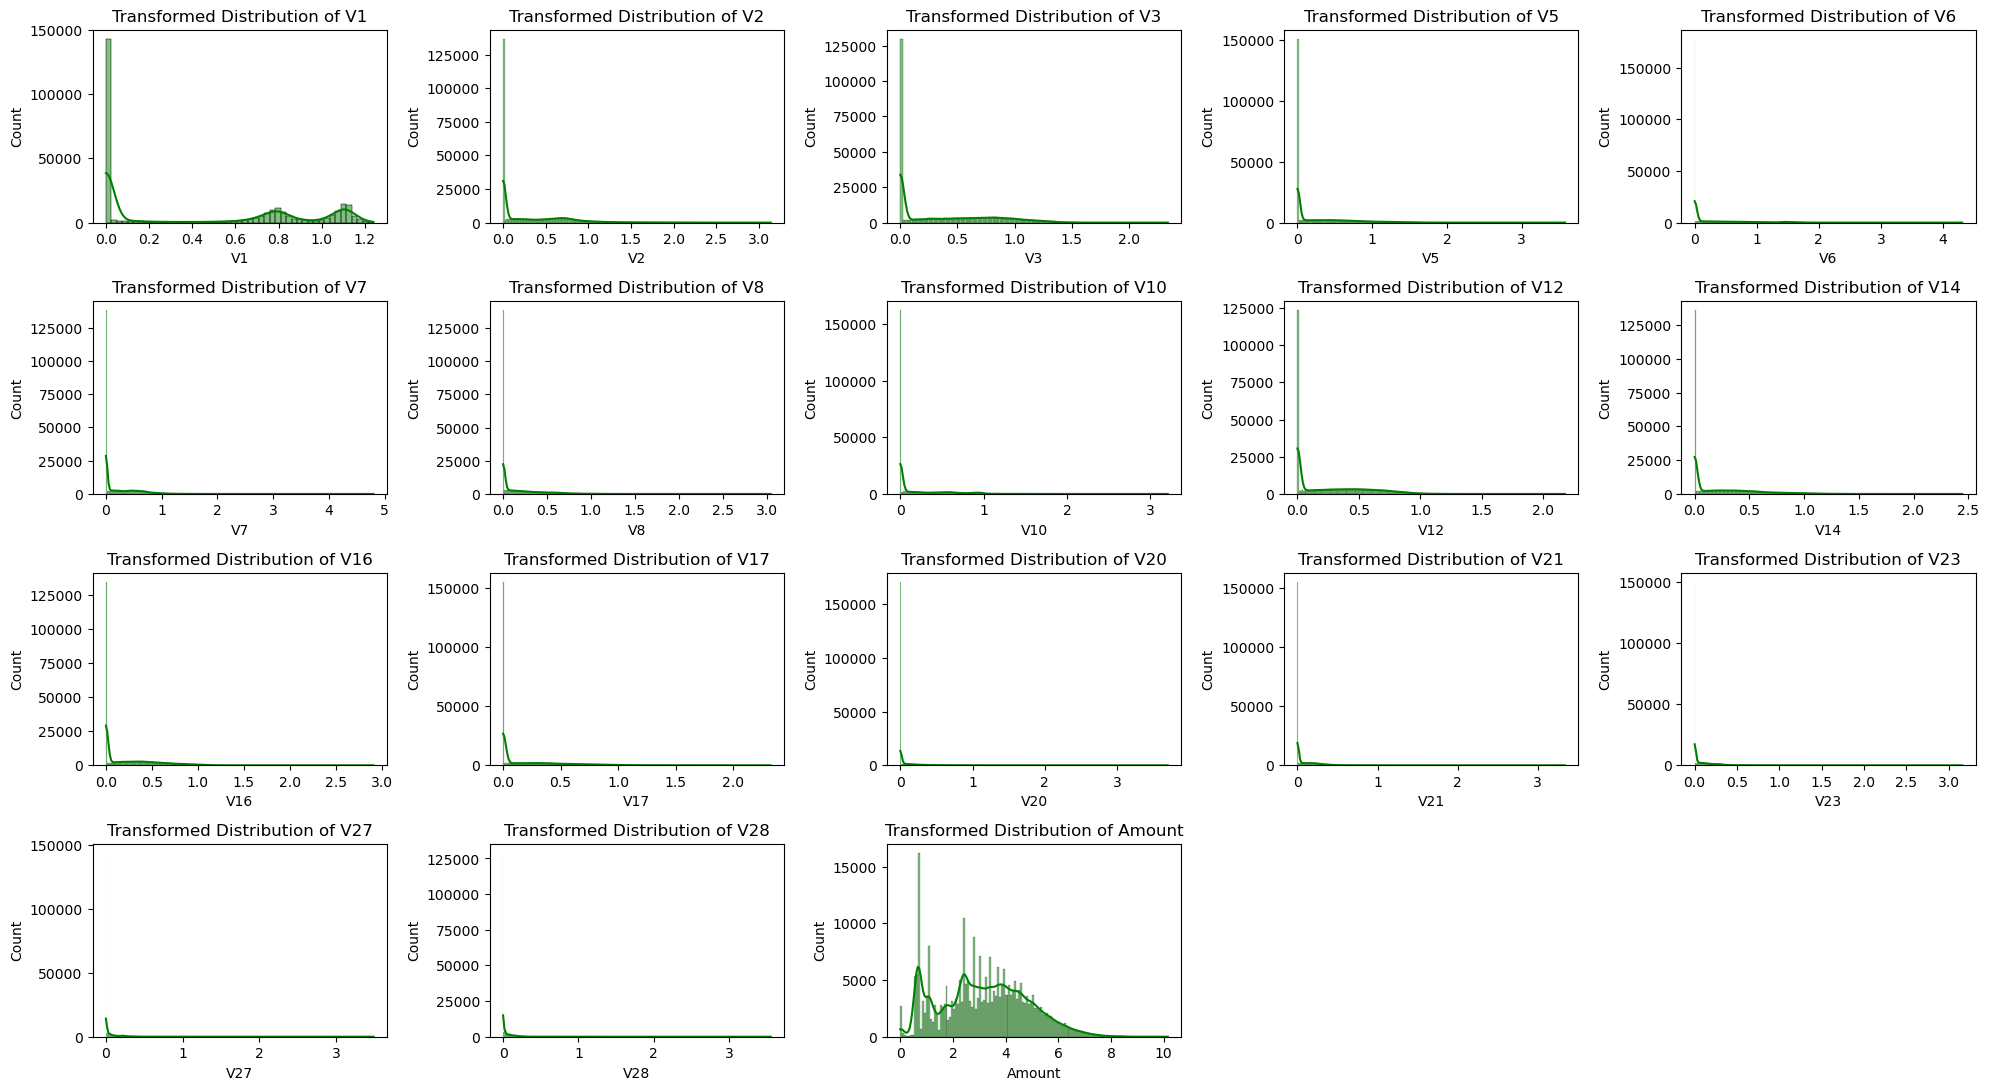

In [13]:
# Plot transformed distributions
plt.figure(figsize=(20, 16))
for i, col in enumerate(skewness[abs(skewness) > 1].index):
    plt.subplot(6, 5, i+1)
    sns.histplot(df_imputed[col], kde=True, color='green')
    plt.title(f'Transformed Distribution of {col}')
plt.tight_layout()
plt.show()


In [14]:
# Separate features and target variable
print(df_imputed['Class'].value_counts())  # Print the count of each class
print(df_imputed['Class'].value_counts(normalize=True))  # Print the percentage of each class

Class
0.0    284315
1.0       492
Name: count, dtype: int64
Class
0.0    0.998273
1.0    0.001727
Name: proportion, dtype: float64


In [15]:
# Separate features (X) and target variable (y)
X = df_imputed.drop('Class', axis=1)
y = df_imputed['Class']

In [16]:

# Split the data into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [17]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Handle missing values before applying SMOTE (this step is crucial to avoid NaN errors in SMOTE)
imputer = SimpleImputer(strategy='mean')  # Re-apply imputation to scaled data
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)


In [19]:

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)

In [20]:
# Model Construction
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB()
}


In [21]:
# Function to calculate Area Under the Precision-Recall Curve (AUCPR)
def calculate_aucpr(model, X_test, y_test):
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    return auc(recall, precision)
    

In [22]:
# Comparing Models
results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    
    # Calculate AUCPR
    aucpr = calculate_aucpr(model, X_test_imputed, y_test)
    
    # Store the results
    results[name] = aucpr
    
    # Print the AUCPR for each model
    print(f'{name} AUCPR: {aucpr}')

K-Nearest Neighbors AUCPR: 0.7273095380361176
Logistic Regression AUCPR: 0.644679728719122
Support Vector Machine AUCPR: 0.5967194455975708
Random Forest AUCPR: 0.8026847071576437
Naive Bayes AUCPR: 0.43760335708238185


In [23]:
# CNN Model
cnn_model = Sequential([
    Conv1D(32, 2, activation='relu', input_shape=(X_train_imputed.shape[1], 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

D:\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Reshape data for CNN
X_train_cnn = X_train_imputed.reshape((X_train_imputed.shape[0], X_train_imputed.shape[1], 1))
X_test_cnn = X_test_imputed.reshape((X_test_imputed.shape[0], X_test_imputed.shape[1], 1))

cnn_model.fit(X_train_cnn, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)
y_proba_cnn = cnn_model.predict(X_test_cnn).ravel()
results['CNN'] = average_precision_score(y_test, y_proba_cnn)
print(f"CNN AUCPR: {results['CNN']:.4f}")

Epoch 1/5
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.5472 - loss: 0.0449 - val_AUC: 0.9126 - val_loss: 0.0053
Epoch 2/5
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.9114 - loss: 0.0044 - val_AUC: 0.9129 - val_loss: 0.0047
Epoch 3/5
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.9159 - loss: 0.0044 - val_AUC: 0.9139 - val_loss: 0.0050
Epoch 4/5
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.9267 - loss: 0.0042 - val_AUC: 0.9140 - val_loss: 0.0044
Epoch 5/5
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.9369 - loss: 0.0030 - val_AUC: 0.9142 - val_loss: 0.0048
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 2s 638us/step
CNN AUCPR: 0.7086


In [25]:
# RNN Model with corrected input handling
rnn_model = Sequential([
    Input(shape=(X_train_imputed.shape[1], 1)),  # Use Input layer
    LSTM(32),
    Dense(1, activation='sigmoid')
])
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

rnn_model.fit(X_train_cnn, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)
y_proba_rnn = rnn_model.predict(X_test_cnn).ravel()
results['RNN'] = average_precision_score(y_test, y_proba_rnn)
print(f"RNN AUCPR: {results['RNN']:.4f}")

Epoch 1/5
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - AUC: 0.5692 - loss: 0.0428 - val_AUC: 0.8049 - val_loss: 0.0112
Epoch 2/5
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - AUC: 0.7982 - loss: 0.0097 - val_AUC: 0.8329 - val_loss: 0.0071
Epoch 3/5
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - AUC: 0.8297 - loss: 0.0059 - val_AUC: 0.8790 - val_loss: 0.0060
Epoch 4/5
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - AUC: 0.8838 - loss: 0.0053 - val_AUC: 0.9049 - val_loss: 0.0054
Epoch 5/5
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - AUC: 0.9142 - loss: 0.0050 - val_AUC: 0.8415 - val_loss: 0.0061
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
RNN AUCPR: 0.5289


In [26]:
# Print results and metrics for each model
for model_name, aucpr in results.items():
    print(f"{model_name} AUCPR: {aucpr:.4f}")


K-Nearest Neighbors AUCPR: 0.7273
Logistic Regression AUCPR: 0.6447
Support Vector Machine AUCPR: 0.5967
Random Forest AUCPR: 0.8027
Naive Bayes AUCPR: 0.4376
CNN AUCPR: 0.7086
RNN AUCPR: 0.5289


In [27]:

# Discuss and Summarize the best model(s)
best_model = max(results, key=results.get)
print(f"The best model is {best_model} with an AUCPR of {results[best_model]:.4f}")

The best model is Random Forest with an AUCPR of 0.8027
